In [2]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import random


In [4]:
!pip install tensorflow

import tensorflow as tf


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

In [8]:
##LOAD THE DATAPATH
train_dir = "/Users/gouthamjekkula/Desktop/Plastic train"
test_dir  = "/Users/gouthamjekkula/Desktop/Plastic test"

In [10]:
def count_images(directory):
    counts = {'Plastic': 0, 'No-Plastic': 0}
    for category in counts.keys():
        path = os.path.join(directory, category)
        if os.path.isdir(path):
            counts[category] = len([f for f in os.listdir(path) if f.endswith(('.jpg', '.jpeg', '.png'))])
    return counts

train_counts = count_images(train_dir)
test_counts = count_images(test_dir)


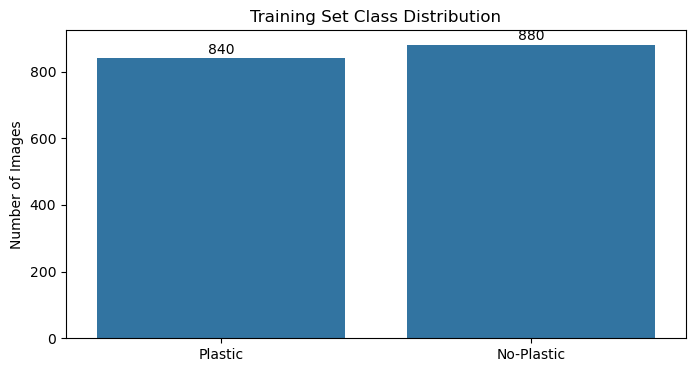

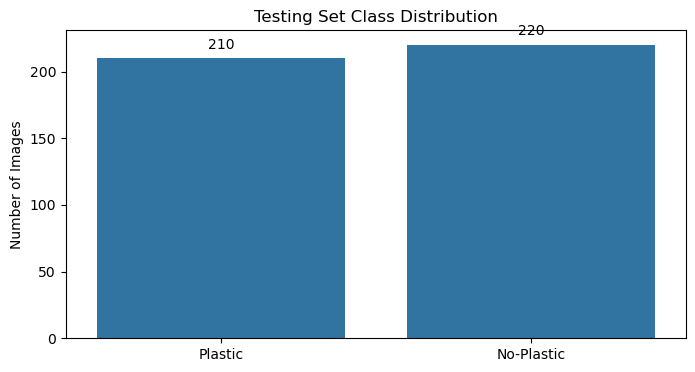

In [12]:

# Bar plots with count labels
plt.figure(figsize=(8, 4))
ax = sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()))
plt.title("Training Set Class Distribution")
plt.ylabel("Number of Images")
for i, val in enumerate(train_counts.values()):
    ax.text(i, val + 5, str(val), ha='center', va='bottom')
plt.show()

plt.figure(figsize=(8, 4))
ax = sns.barplot(x=list(test_counts.keys()), y=list(test_counts.values()))
plt.title("Testing Set Class Distribution")
plt.ylabel("Number of Images")
for i, val in enumerate(test_counts.values()):
    ax.text(i, val + 5, str(val), ha='center', va='bottom')
plt.show()


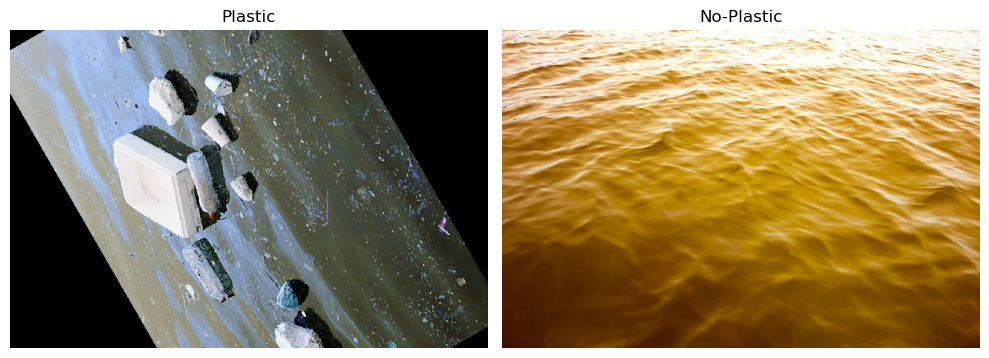

In [183]:

# Displayed the sample images
def show_samples(directory):
    plt.figure(figsize=(10, 5))
    classes = ['Plastic', 'No-Plastic']
    for i, cls in enumerate(classes):
        path = os.path.join(directory, cls)
        img = Image.open(os.path.join(path, random.choice(os.listdir(path))))
        plt.subplot(1, 2, i+1)
        plt.imshow(img)
        plt.title(cls)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_samples(train_dir)



In [185]:
# Image Preprocessing
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    train_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, class_mode='binary')
test_data = test_gen.flow_from_directory(
    test_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, class_mode='binary', shuffle=False)

Found 1720 images belonging to 2 classes.
Found 430 images belonging to 2 classes.


In [187]:
# Model 1: Custom CNN
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

cnn_history = cnn_model.fit(train_data, epochs=10, validation_data=test_data)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.5342 - loss: 1.2429 - val_accuracy: 0.6953 - val_loss: 0.6514
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 52s 964ms/step - accuracy: 0.7522 - loss: 0.5522 - val_accuracy: 0.6651 - val_loss: 0.6376
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 52s 967ms/step - accuracy: 0.7749 - loss: 0.4809 - val_accuracy: 0.6419 - val_loss: 0.6971
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 52s 968ms/step - accuracy: 0.7813 - loss: 0.4820 - val_accuracy: 0.6326 - val_loss: 0.6588
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 52s 960ms/step - accuracy: 0.8035 - loss: 0.4560 - val_accuracy: 0.7279 - val_loss: 0.5347
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 52s 956ms/step - accuracy: 0.8128 - loss: 0.3920 - val_accuracy: 0.7302 - val_loss: 0.6279
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 52s 974ms/step - accuracy: 0.8164 - loss: 0.3866 - val_accuracy: 0.7395 - val_loss: 0.6499
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 52s 966ms/step - accuracy: 0.8180 - loss: 0.3633 - val_accurac

In [188]:
# Model 2: ResNet50 Transfer Learning

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

resnet_model = Model(inputs=base_model.input, outputs=predictions)
resnet_model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

resnet_history = resnet_model.fit(train_data, epochs=10, validation_data=test_data)


Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.5339 - loss: 1.4979 - val_accuracy: 0.7186 - val_loss: 0.5544
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.6450 - loss: 0.6288 - val_accuracy: 0.7023 - val_loss: 0.5723
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.6556 - loss: 0.6282 - val_accuracy: 0.7140 - val_loss: 0.5428
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.6725 - loss: 0.6144 - val_accuracy: 0.7302 - val_loss: 0.5440
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.6897 - loss: 0.6039 - val_accuracy: 0.7209 - val_loss: 0.5492
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.7074 - loss: 0.5802 - val_accuracy: 0.7442 - val_loss: 0.5293
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.6695 - loss: 0.6036 - val_accuracy: 0.7419 - val_loss: 0.5248
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.7033 - loss: 0.5872 - val_accuracy: 0.7465 - val_loss:

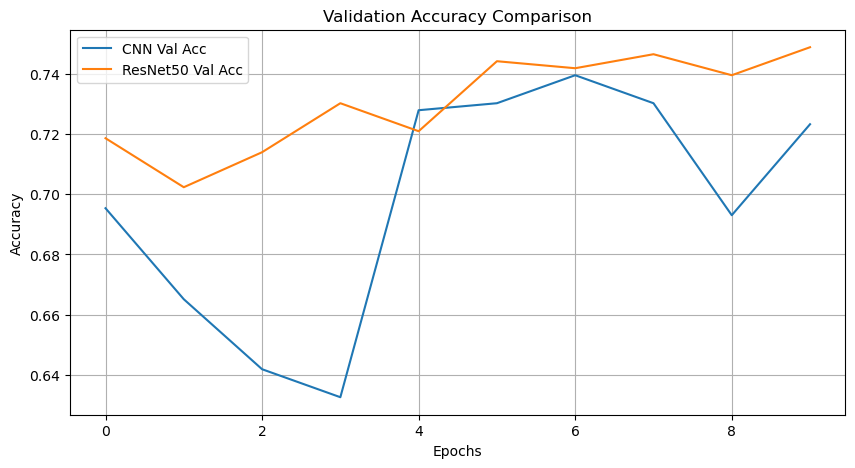

In [189]:
#Validation Accuracy Comparison Plot
plt.figure(figsize=(10, 5))
plt.plot(cnn_history.history['val_accuracy'], label='CNN Val Acc')
plt.plot(resnet_history.history['val_accuracy'], label='ResNet50 Val Acc')
plt.title("Validation Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()



Model: CNN
14/14 ━━━━━━━━━━━━━━━━━━━━ 14s 831ms/step
              precision    recall  f1-score   support

  No-Plastic       0.75      0.70      0.72       220
     Plastic       0.70      0.75      0.73       210

    accuracy                           0.72       430
   macro avg       0.72      0.72      0.72       430
weighted avg       0.72      0.72      0.72       430



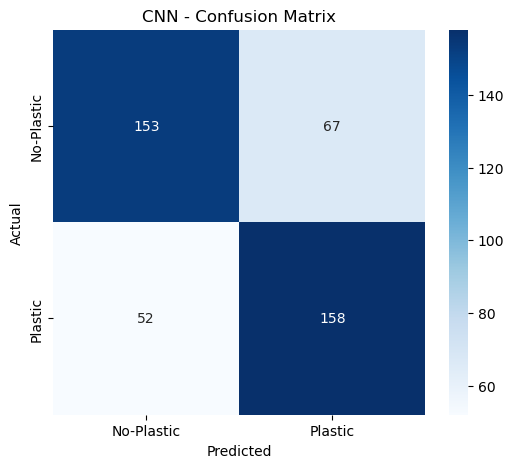


Model: ResNet50
14/14 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step
              precision    recall  f1-score   support

  No-Plastic       0.79      0.69      0.74       220
     Plastic       0.71      0.81      0.76       210

    accuracy                           0.75       430
   macro avg       0.75      0.75      0.75       430
weighted avg       0.75      0.75      0.75       430



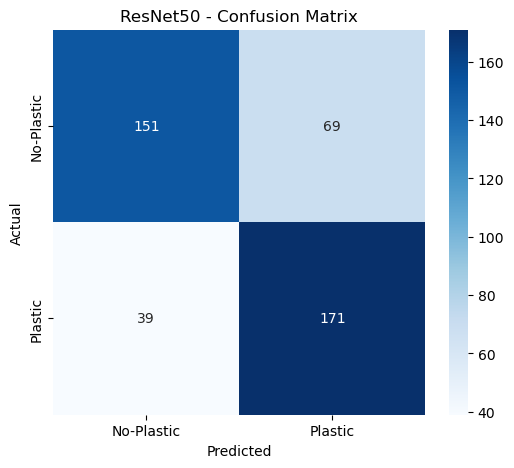

In [190]:
#Confusion Matrix
label_map = {0: 'No-Plastic', 1: 'Plastic'}
models = {'CNN': cnn_model, 'ResNet50': resnet_model}

for name, model in models.items():
    print(f"\nModel: {name}")
    preds = model.predict(test_data)
    preds_bin = (preds > 0.5).astype(int).flatten()
    true = test_data.classes

    pred_labels = [label_map[p] for p in preds_bin]
    true_labels = [label_map[t] for t in true]

    print(classification_report(true_labels, pred_labels, target_names=label_map.values()))

    cm = confusion_matrix(true_labels, pred_labels, labels=list(label_map.values()))
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.values(), yticklabels=label_map.values())
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [191]:
# Prediction Function Code on Test Image
def predict_image(model, image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.
    img_array = np.expand_dims(img_array, axis=0)
    pred = model.predict(img_array)[0][0]
    label = "Plastic" if pred > 0.5 else "No-Plastic"

    # Show the image with prediction title
    plt.imshow(img)
    plt.title(f"Prediction: {label}")
    plt.axis('off')
    plt.show()

    return label



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


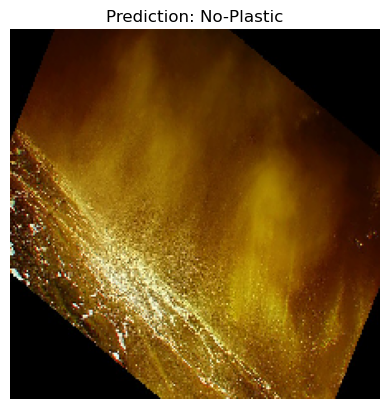

No-Plastic


In [192]:
print(predict_image(resnet_model, "/Users/gouthamjekkula/Desktop/Plastic test/no-plastic/no_plasic (892).jpg"))


In [193]:
# Save best model
resnet_model.save('marine_pollution_resnet50.h5')
print("Model saved as 'marine_pollution_resnet50.h5'")


Model saved as 'marine_pollution_resnet50.h5'


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


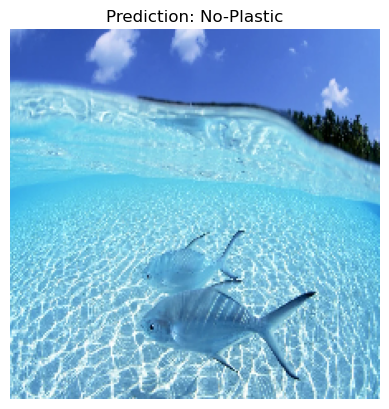

No-Plastic


In [194]:
#Prediction Function Code on online image
from tensorflow.keras.preprocessing import image

def predict_image_from_local(model, image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)[0][0]
    label = "Plastic" if prediction > 0.5 else "No-Plastic"

    # Show image
    plt.imshow(img)
    plt.title(f"Prediction: {label}")
    plt.axis('off')
    plt.show()

    return label

# Example usage:
local_image_path = "/Users/gouthamjekkula/Desktop/clear water.jpg"
print(predict_image_from_local(resnet_model, local_image_path))